# Assignment 3

Welcome to the assignment for week 3.

## Task 3: Hough Transform

There are two datasets available: "images/eye_tracking" and "images/lane_detection". Implement the classical Hough Transform for lines (lane detection) and circles (eye tracking) as shown in the lecture. Use any Canny Edge Detector implementation to produce edge images.

To pass this assignment, we want you to solve (Task 3.1 OR Task 3.2) AND Task 3.3. The BONUS Task 3.4 is optional as well as one of the first 2 tasks. If you are confused, just solve all of them!

In [157]:
# imports
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, feature, color, filters
from matplotlib.patches import Circle
from tqdm.notebook import tqdm
from skimage.draw import line
import math
import numpy as np

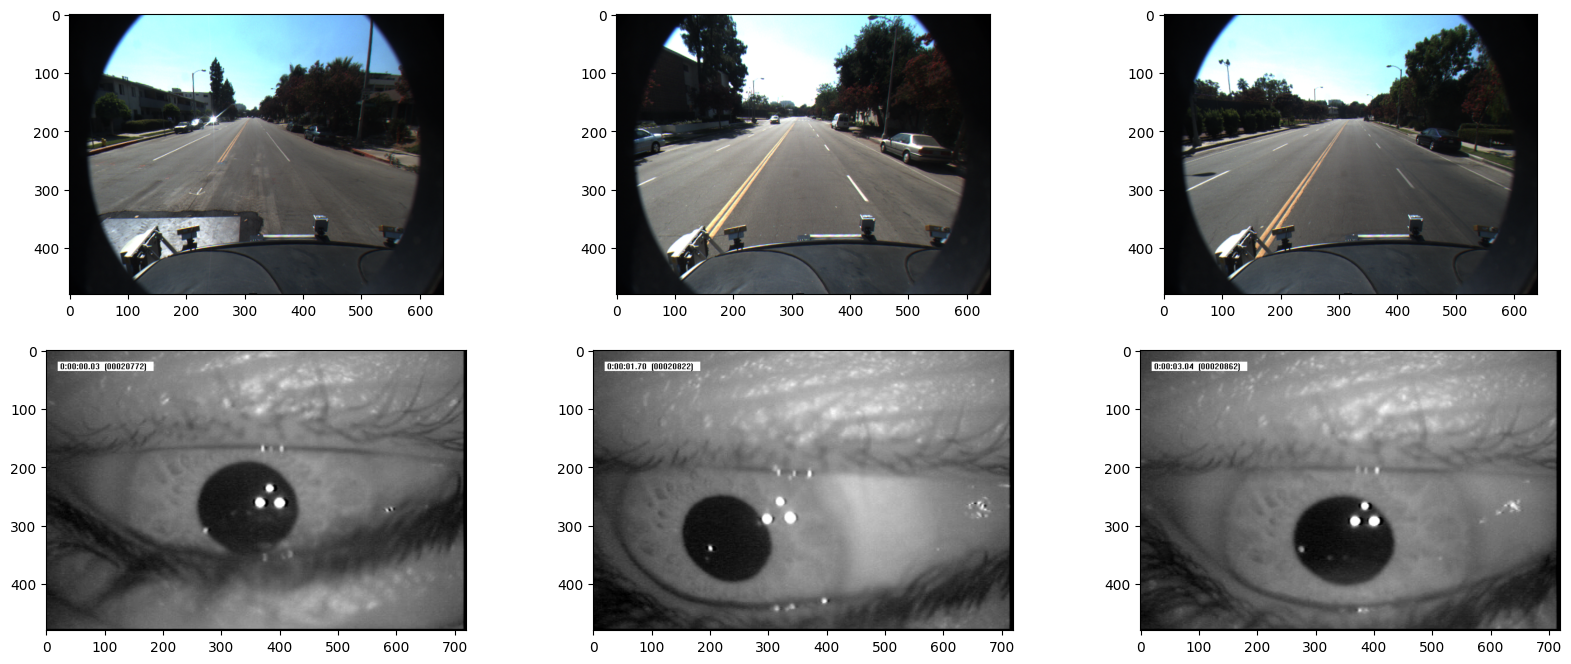

In [158]:
# Plotting some samples
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00050.png')
lane3 = io.imread('images/lane_detection/f00090.png')
eye1 = io.imread('images/eye_tracking/0000.jpeg')
eye2 = io.imread('images/eye_tracking/0050.jpeg')
eye3 = io.imread('images/eye_tracking/0090.jpeg')

fig = plt.figure(figsize=(20, 8))
ax11 = plt.subplot(2, 3, 1)
ax12 = plt.subplot(2, 3, 2)
ax13 = plt.subplot(2, 3, 3)
ax21 = plt.subplot(2, 3, 4)
ax22 = plt.subplot(2, 3, 5)
ax23 = plt.subplot(2, 3, 6)

ax11.imshow(lane1)
ax12.imshow(lane2)
ax13.imshow(lane3)
ax21.imshow(eye1)
ax22.imshow(eye2)
ax23.imshow(eye3)

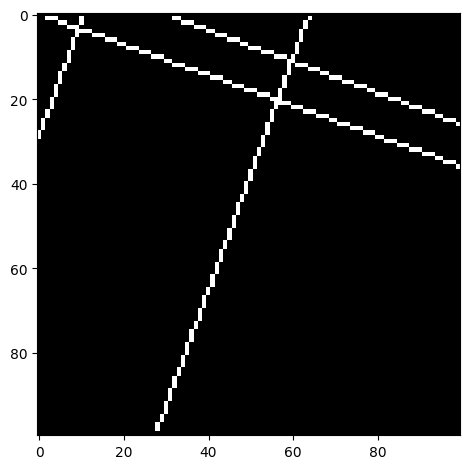

In [159]:
def draw_line_hessian_normal(image, a, r):
    
    (dimy,dimx) = image.shape

    #r = x*cosa + y*sina

    # compute start and end point of line 
    x0 = 0
    y0 = round((r - x0*math.cos(math.radians(a)))/math.sin(math.radians(a)))
    x1 = dimx
    y1 = round((r - x1*math.cos(math.radians(a)))/math.sin(math.radians(a)))

    liney,linex = line(y0,x0,y1,x1)
    
    ret = np.copy(image)
    for yy in range(0,liney.size-1):
        if (liney[yy] > 0) and (liney[yy] < dimy-1):
            ret[liney[yy],linex[yy]] = 1
    return ret

image = np.zeros((100,100))
image = draw_line_hessian_normal(image, 20, 60)
image = draw_line_hessian_normal(image, 20, 10)
image = draw_line_hessian_normal(image, 110, 0)
image = draw_line_hessian_normal(image, -70, 10)
io.imshow(image)

### Task 3.1: Detecting lanes

Put your Lane Detection solution here.

* Use your implementation of the Hough Transform to find the 10 strongest lines in one lane_detection image
* Display your result set (draw those lines on the image) (**RESULT**)
* Can you improve the performance by limiting the space of solutions?

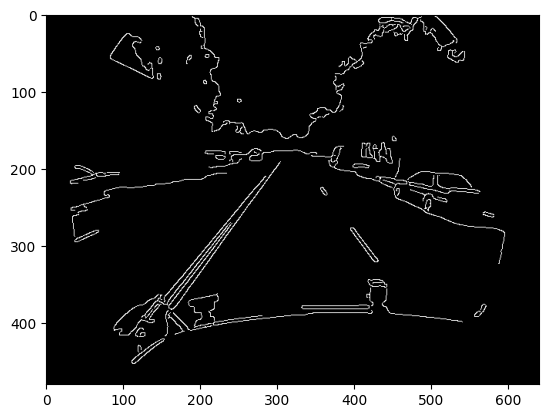

In [160]:
image = lane2.copy()
image = feature.canny(color.rgb2gray(image), sigma=1.5, low_threshold=0.2, high_threshold=0.5)

plt.imshow(image, cmap='gray')

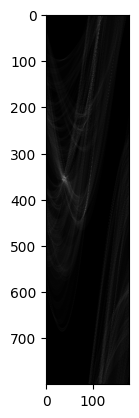

In [161]:
# r_granularity = 1
max_r = math.sqrt(image.shape[0]**2 + image.shape[1]**2)

a_granularity = 1
max_a = 180

array = np.zeros(
    (int(np.ceil(max_r)), max_a)
)

for y, row in enumerate(image):
    for x, pixel in enumerate(row):
        if pixel:
            for a in range(0, max_a, a_granularity):
                r = x*math.cos(math.radians(a)) + y*math.sin(math.radians(a))
                r = round(r)
                array[r, a] += 1

plt.imshow(array, cmap='gray')

[(36, 358), (40, 353), (38, 354), (39, 352), (38, 358), (39, 351), (35, 356), (39, 356), (37, 355), (37, 351)]


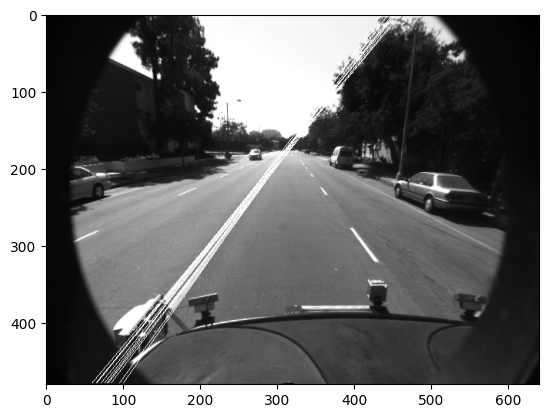

In [162]:
# note: for a better result non-maximum suppression should be applied on the accumulator
k=10

result = color.rgb2gray(lane2)
# result = np.zeros(lane2.shape[:2])

strongest_lines = sorted(
    (
        (a, r) 
        for a in range(0, max_a, a_granularity) 
        for r in range(0, int(max_r))
    ),
    key=lambda x: array[x[1], x[0]],
    reverse=True
)[:k]

print(strongest_lines)

for a, r in strongest_lines:
    result = draw_line_hessian_normal(result, a, r)

plt.imshow(result, cmap='gray')

### Task 3.2: Eye Tracker

Put your Eye Tracker solution here.

* Use your implementation of the Hough Transform to find the 10 strongest circles in one eye_tracking sample image
* Display your result set (draw those circles on the image) (**RESULT**)
* Can you improve the performance by limiting the space of solutions?

In [163]:
...

Ellipsis

### Task 3.3: Generalized Hough Transform

* Implement the Generalized Hough Transform as described in the lecture for localizing a given template
* Find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

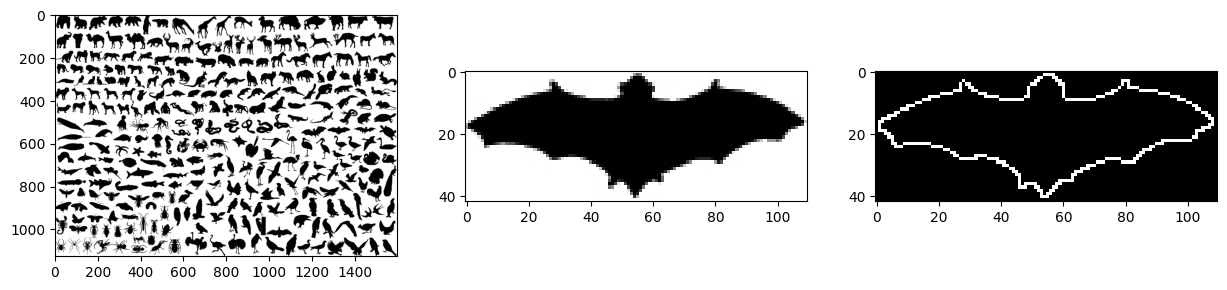

In [164]:
animals_color = io.imread('images/animals.png')
animals = color.rgb2gray(animals_color)

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals[ymin:ymax, xmin:xmax]
bat_edge = feature.canny(bat, 0.5)

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(animals, cmap='gray')
ax2.imshow(bat, cmap='gray')
ax3.imshow(bat_edge, cmap='gray')

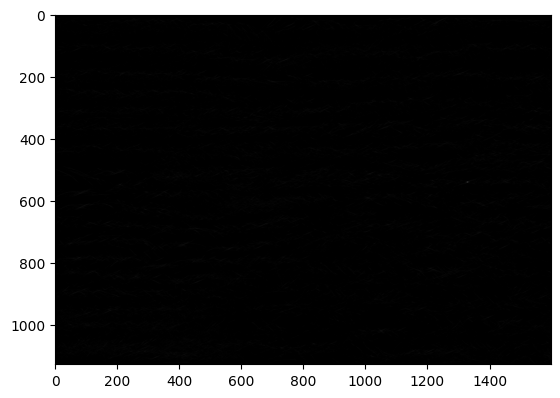

In [165]:
from collections import defaultdict
from contextlib import suppress

# we use a part of the canny algorithm from assignment 2 to get the gradients

x_sobel = filters.sobel(bat, axis=1)
y_sobel = filters.sobel(bat, axis=0)

def angle_between_points(p1, p2):
    """
    Returns the angle between two points between 0 and 360 degrees.
    """

    x1, y1 = p1
    x2, y2 = p2

    dot = x1 * x2 + y1 * y2
    det = x1 * y2 - y1 * x2

    rv = np.arctan2(det, dot) * 180 / np.pi
    return rv if rv >= 0 else 360 + rv

angle_prec = 20

# center
h,w = bat.shape
c = (h//2, w//2)

r_table = defaultdict(list)

for y, row in enumerate(bat_edge):
    for x, pixel in enumerate(row):
        if pixel:
            vec = (c[0]-y, c[1]-x)
            angle = angle_between_points((x_sobel[y, x], y_sobel[y, x]), (0, 1))
            angle = round(angle/angle_prec)*angle_prec
            r_table[angle].append(vec)

acc = np.zeros_like(animals)

x_sobel = filters.sobel(animals, axis=1)
y_sobel = filters.sobel(animals, axis=0)
animals_edge = feature.canny(animals, 0.5)

plt.imshow(animals_edge, cmap='gray')

for y, row in enumerate(animals_edge):
    for x, pixel in enumerate(row):
        if pixel:
            angle = angle_between_points((x_sobel[y, x], y_sobel[y, x]), (0, 1))
            angle = round(angle/angle_prec)*angle_prec
            for r in r_table[angle]:
                with suppress(IndexError):
                    acc[y+r[0], x+r[1]] += 1

# print(dict(r_table))
plt.imshow(acc, cmap='gray')


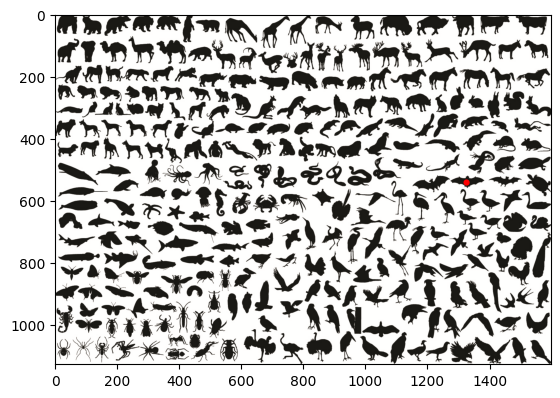

In [166]:
pos = np.unravel_index(np.argmax(acc, axis=None), acc.shape)

fig, ax = plt.subplots()
ax.imshow(animals_color)

circle = Circle((pos[1], pos[0]), 10, facecolor='red', fill=True)
ax.add_patch(circle)

plt.show()


### Task 3.4 (BONUS) 
* Implement an extended version of the GHT that find scaled and rotated variants of the template
* Find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.jpg")
* Note that you can binarize your italy template by using a simple color lookup
* Draw the location of italy on the map and print its scale and rotation (**BONUS**)

In [167]:
# code here

## Congratz, you made it! :)